In [18]:
import pandas as pd
from transformers import pipeline
from transformers import AutoModelForCausalLM, AutoTokenizer, TextGenerationPipeline
import matplotlib.pyplot as plt
from dotenv import load_dotenv 
import os
import re
from tqdm import tqdm
    
import io
import sys
load_dotenv()


True

In [19]:
device = "cuda"

In [ ]:
!huggingface-cli scan-cache

In [20]:
deepseek_model = {
    "tokenizer": AutoTokenizer.from_pretrained("deepseek-ai/deepseek-coder-7b-instruct-v1.5"),
    "model" : AutoModelForCausalLM.from_pretrained("deepseek-ai/deepseek-coder-7b-instruct-v1.5")
}

# mistral_model = {
#     "tokenizer": AutoTokenizer.from_pretrained("mistralai/Mistral-7B-Instruct-v0.2"),
#     "model" : AutoModelForCausalLM.from_pretrained("mistralai/Mistral-7B-Instruct-v0.2")
# }

# codellama_model = {
#     "tokenizer": AutoTokenizer.from_pretrained("codellama/CodeLlama-7b-Instruct-hf"),
#     "model" : AutoModelForCausalLM.from_pretrained("codellama/CodeLlama-7b-Instruct-hf")
# }


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [21]:
prompt_template = """df is a dataframe that {description}. df has these columns: {columns}. Without explaining, write in a python code block the answer to this question: Print {question}
"""
prompt_template = """df is a dataframe that {description}. df has these columns: {columns}. Write in a python code block the answer to this question: Print {question}. Just code, no explanation should be given.
"""

prompt_template = """df is a dataframe that {description}. df has these columns: {columns}. Write in a python code block the answer to this question: {question}. Just write code and print results, no explanation should be given.
"""

libraries = """
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import seaborn as sns
from scipy import stats
"""

In [22]:
def extract_code(text):
    try:
        matches = []
        # pattern = r"```(.*?)```"
        pattern = r"```python(.*?)```"
        if text:
            matches = re.findall(pattern, text, re.DOTALL)
        if matches:
            return matches[0]
        else:
            raise Exception("Error extracting code: No match")
    except Exception as e:
        raise Exception("Error extracting code: ",e) from e

def generate_response(prompt,model_name):
    try:
        coder_model_prompt = [
        {"role": "user", "content": prompt}
        ]
        encodeds = model_name["tokenizer"].apply_chat_template(coder_model_prompt, return_tensors="pt")

        model_inputs = encodeds.to(device)
        model_name['model'].to(device)

        generated_ids = model_name['model'].generate(model_inputs, max_new_tokens=500, do_sample=False,temperature=0.1,repetition_penalty=1)
        decoded = model_name["tokenizer"].batch_decode(generated_ids)
        return decoded[0].split('[/INST]')[-1].split('</s>')[0]
    except Exception as e:
        raise Exception("Error generating: ",e) from e

def execute(code,namespace):
    try:
        buffer = io.StringIO()
        sys.stdout = buffer
        exec(libraries+code,namespace)

        sys.stdout = sys.__stdout__

        return buffer.getvalue()

    except Exception as e:
        raise Exception("Error executing: ",e) from e

In [23]:
filename = "titanic.csv"
df = pd.read_csv(f'./testing/datasets/{filename}')
answer1 = df[df['Name'] == "Mr. Owen Harris Braund"]['Fare'].iloc[0]
answer2 = df[df['Sex'] == "female"].shape[0]
answer3 = df['Age'].mean()
answer4 = df[df['Survived'] == 1].shape[0]
answer5 = df.loc[df['Fare'].idxmax(), 'Name']
answer6 = df['Fare'].sum()
answer7 = df.loc[df['Siblings/Spouses Aboard'].idxmax(), 'Name']
answer8 = df[df['Name'] == "Miss. Laina Heikkinen"]['Age'].iloc[0]
answer9 = df[df['Pclass'] == 1].shape[0]
answer10 = df['Fare'].mean()
answer11 = df[df['Siblings/Spouses Aboard'] == 0].shape[0]
answer12 = df.loc[df['Age'].idxmax(), 'Name']
answer13 = df[df['Survived'] == 0].shape[0]
answer14 = df['Fare'].min()

TC1_questions = [
    {'question': 'What is the fare for Mr. Owen Harris Braund?', 'answer': answer1},
    {'question': 'How many females are in the dataset?', 'answer': answer2},
    {'question': 'What is the average age of the passengers?', 'answer': answer3},
    {'question': 'How many passengers survived?', 'answer': answer4},
    {'question': 'Who paid the highest fare?', 'answer': answer5},
    {'question': 'What is the total amount of fare paid?', 'answer': answer6},
    {'question': 'Who is the passanger that has the highest number of siblings abroad ?', 'answer': answer7},
    {"question": "What is the age of Miss. Laina Heikkinen?", "answer": answer8},
    {"question": "How many passengers are in the 1st class?", "answer": answer9},
    {"question": "What is the average fare paid by passengers?", "answer": answer10},
    {"question": "How many passengers have 0 siblings/spouses aboard?", "answer": answer11},
    {"question": "Who is the oldest passenger in the dataset?", "answer": answer12},
    {"question": "How many passengers did not survive?", "answer": answer13},
    {"question": "What is the lowest fare paid in the dataset?", "answer": answer14}
]

TC1_description = 'contains the list of people that were on the titanic ship and some details such as age, sex, name and whether they survived or not'
TC1_columns = "['Survived', 'Pclass', 'Name', 'Sex', 'Age', 'Siblings/Spouses Aboard', 'Parents/Children Aboard', 'Fare']"

TC1 = {
    "dataset":filename,
    "description":TC1_description,
    "columns":TC1_columns,
    "questions": TC1_questions,
}

In [24]:
filename = "onlinefoods.csv"
df = pd.read_csv(f'./testing/datasets/{filename}')
answer1 = df.loc[df['Gender'] == "Female", 'Monthly Income'].iloc[0]
answer2 = (df['Occupation'] == "Student").sum()
answer3 = df['Age'].mean()
answer4 = (df['Feedback'] == "Positive").sum()
answer5= df[df['Gender'] == 'Male']['Educational Qualifications'].unique()
answer6 = (df['Marital Status'] == "Single").sum()
answer7 = df['Marital Status'].mode()[0]
answer8 = "Yes" if any(df['Family size'] > 3) else "No"
answer9 = df.loc[df['latitude'].idxmax(), 'Pin code']
answer10 = "Yes" if any((df['Feedback'] == "Negative") & (df['Monthly Income'] == "Below Rs.10000")) else "No"

TC2_questions=[
    {"question": "What is the monthly income of the first female in the dataset?", "answer": answer1},
    {"question": "How many students are there in the dataset?", "answer": answer2},
    {"question": "What is the average age of participants?", "answer": answer3},
    {"question": "How many participants provided positive feedback?", "answer": answer4},
    {"question": "What is the educational qualification of the male participant?", "answer": answer5},
    {"question": "How many participants are single?", "answer": answer6},
    {"question": "What is the most common marital status in the dataset?", "answer": answer7},
    {"question": "Are there any participants with a family size greater than 3?", "answer": answer8},
    {"question": "What is the pin code for the location with the highest latitude?", "answer": answer9},
    {"question": "Did any participant with negative feedback have a monthly income below Rs.10000?", "answer": answer10}
]

TC2_description = 'The dataset contains information collected from an online food ordering platform over a period of time.'
TC2_columns = "['Age', 'Gender', 'Marital Status', 'Occupation', 'Monthly Income', 'Educational Qualifications', 'Family size', 'latitude', 'longitude', 'Pin code', 'Output', 'Feedback', 'Unnamed: 12']"

TC2 = {
    "dataset":filename,
    "description":TC2_description,
    "columns":TC2_columns,
    "questions": TC2_questions,
}

In [25]:
filename = "hw_200.csv"
df = pd.read_csv(f'./testing/datasets/{filename}')
answer1 = df.loc[1, 'Weight(Pounds)']
answer2 = df[df['Height(Inches)'] > 70].shape[0]
answer3 = df['Height(Inches)'].mean()
answer4 = df[df['Weight(Pounds)'] < 120].shape[0]
answer5 = df.loc[df['Weight(Pounds)'].idxmax(), 'Index']
answer6 = df['Weight(Pounds)'].sum()
answer7 = df.loc[df['Height(Inches)'].idxmin(), 'Index']
answer8 = df.loc[3, 'Height(Inches)']
answer9 = df[df['Height(Inches)'] >= 65].shape[0]
answer10 = df['Weight(Pounds)'].mean()
answer11 = df[df['Weight(Pounds)'] == 100].shape[0]
answer12 = df.loc[df['Height(Inches)'].idxmax(), 'Index']
answer13 = df[df['Weight(Pounds)'] > 150].shape[0]
answer14 = df['Height(Inches)'].min()


TC3_description ="height and weight for 200 individuals"
TC3_columns = "['Index', 'Height(Inches)', 'Weight(Pounds)']"

TC3_questions = [
    {'question': 'What is the weight of the person at index 1?', 'answer': answer1},
    {'question': 'How many people are taller than 70 inches?', 'answer': answer2},
    {'question': 'What is the average height of the people?', 'answer': answer3},
    {'question': 'How many people weigh less than 120 pounds?', 'answer': answer4},
    {'question': 'Who has the highest weight?', 'answer': answer5},
    {'question': 'What is the total weight of all people?', 'answer': answer6},
    {'question': 'Who is the shortest person?', 'answer': answer7},
    {"question": "What is the height of the person at index 3?", "answer": answer8},
    {"question": "How many people are at least 65 inches tall?", "answer": answer9},
    {"question": "What is the average weight of the people?", "answer": answer10},
    {"question": "How many people weigh exactly 100 pounds?", "answer": answer11},
    {"question": "Who is the tallest person?", "answer": answer12},
    {"question": "How many people weigh more than 150 pounds?", "answer": answer13},
    {"question": "What is the lowest height recorded in the dataset?", "answer": answer14}
]

TC3 = {
    "dataset":filename,
    "description":TC3_description,
    "columns":TC3_columns,
    "questions": TC3_questions,
}


In [26]:
filename = "Monthly_Counts_of_Deaths_by_Select_Causes__2014-2019.csv"
df = pd.read_csv(f'./testing/datasets/{filename}')
answer1 = df[(df['Jurisdiction of Occurrence'] == "United States") & (df['Year'] == 2014)]['Malignant Neoplasms'].sum()
answer2 = df[df['Year'] == 2015]['Natural Cause'].sum()
answer3 = df['Diabetes Mellitus'].mean()
answer4 = df[(df['Year'] == 2015) & (df['Month'] == 1)]['Intentional Self-Harm (Suicide)'].sum()
answer5 = df[(df['Year'] == 2014)]['Accidents (Unintentional Injuries)'].idxmax()
answer6 = df['All Cause'].sum()
answer7 = df.groupby('Year')['Diseases of Heart'].sum().idxmin()
answer8 = df[df['Month'] == 1]['Drug Overdose'].sum()
answer9 = df[df['Chronic Lower Respiratory Diseases'] > 10000].shape[0]
answer10 = df.groupby('Year')['Cerebrovascular Diseases'].mean()
answer11 = df[df['Year'] == 2014]['Motor Vehicle Accidents'].sum()
answer12 = df.groupby('Jurisdiction of Occurrence')['Alzheimer Disease'].sum().idxmax()
answer13 = df[df['Year'] == 2015]['Assault (Homicide)'].sum()
answer14 = df['Influenza and Pneumonia'].min()
answers = [answer1, answer2, answer3, answer4, answer5, answer6, answer7, answer8, answer9, answer10, answer11, answer12, answer13, answer14]

TC4_description ="Monthly counts of death by select causes."
TC4_columns = "['Jurisdiction of Occurrence', 'Year', 'Month', 'All Cause', 'Natural Cause', 'Septicemia', 'Malignant Neoplasms', 'Diabetes Mellitus', 'Alzheimer Disease', 'Influenza and Pneumonia', 'Chronic Lower Respiratory Diseases', 'Other Diseases of Respiratory System', 'Nephritis, Nephrotic Syndrome, and Nephrosis', 'Symptoms, Signs, and Abnormal Clinical and Laboratory Findings, Not Elsewhere Classified', 'Diseases of Heart', 'Cerebrovascular Diseases', 'Accidents (Unintentional Injuries)', 'Motor Vehicle Accidents', 'Intentional Self-Harm (Suicide)', 'Assault (Homicide)', 'Drug Overdose']"

TC4_questions = [
    {'question': 'How many deaths were caused by "Malignant Neoplasms" in the United States in 2014?', 'answer': answer1},
    {'question': 'What is the total number of "Natural Cause" deaths recorded in 2015?', 'answer': answer2},
    {'question': 'What is the average number of deaths by "Diabetes Mellitus" across all years and months?', 'answer': answer3},
    {'question': 'How many deaths were reported as "Intentional Self-Harm (Suicide)" in January 2015?', 'answer': answer4},
    {'question': 'Which month in 2014 had the highest number of "Accidents (Unintentional Injuries)"?', 'answer': answer5},
    {'question': 'What is the total number of all recorded deaths in the dataset?', 'answer': answer6},
    {'question': 'Which year had the lowest "Diseases of Heart" deaths?', 'answer': answer7},
    {"question": "What were the total \"Drug Overdose\" deaths in January across all years?", "answer": answer8},
    {"question": "How many months have recorded more than 10,000 deaths from \"Chronic Lower Respiratory Diseases\"?", "answer": answer9},
    {"question": "What is the average number of deaths due to \"Cerebrovascular Diseases\" each year?", "answer": answer10},
    {"question": "How many \"Motor Vehicle Accidents\" deaths were there in 2014?", "answer": answer11},
    {"question": "Which jurisdiction recorded the highest \"Alzheimer Disease\" deaths in the dataset?", "answer": answer12},
    {"question": "How many \"Assault (Homicide)\" deaths were reported in 2015?", "answer": answer13},
    {"question": "What is the minimum number of \"Influenza and Pneumonia\" deaths recorded in any month?", "answer": answer14}
]

TC4 = {
    "dataset":filename,
    "description":TC4_description,
    "columns":TC4_columns,
    "questions": TC4_questions,
}


In [20]:
def test(qa,description,columns,dataset):
    data = []
    df = pd.read_csv(f'./testing/datasets/{dataset}')
    namespace = {'df': df}
    try: 
        full_response= None
        extracted_code= None
        execution= None
        error = None
        question = qa['question']
        answer = qa['answer']
        prompt = prompt_template.format(description=description,columns=columns,question=question)
        try:
            full_response = generate_response(prompt,mistral_model)
            extracted_code = extract_code(full_response)
            execution = execute(extracted_code,namespace)
        
        except Exception as e:
            error = e

        data.append({   
        'question': question,
        'prompt':prompt,
        'full_response': full_response,
        'extracted_code': extracted_code,
        'execution': execution,
        'answer':answer,
        'error': error
            })
        
        return data
    
    except Exception as e:
        print(e)


In [21]:
data = test(TC1["questions"][3],TC1["description"],TC1["columns"],TC1["dataset"])

/home/zidane/anaconda3/envs/proj_env/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:492: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.1` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


In [22]:
data

[{'question': 'How many passengers survived?',
  'prompt': "df is a dataframe that contains the list of people that were on the titanic ship and some details such as age, sex, name and whether they survived or not. df has these columns: ['Survived', 'Pclass', 'Name', 'Sex', 'Age', 'Siblings/Spouses Aboard', 'Parents/Children Aboard', 'Fare']. Write in a python code block the answer to this question: How many passengers survived?. Just write code and print results, no explanation should be given.\n",
  'full_response': " ```python\n# Assuming df is your DataFrame variable\nnum_survivors = len(df[df['Survived'] == True]['Name'].unique())\nprint(num_survivors)\n```",
  'extracted_code': "\n# Assuming df is your DataFrame variable\nnum_survivors = len(df[df['Survived'] == True]['Name'].unique())\nprint(num_survivors)\n",
  'execution': '342\n',
  'answer': 342,
  'error': None}]

In [25]:
data

[{'question': 'What is the average age of the passengers?',
  'prompt': "df is a dataframe that contains the list of people that were on the titanic ship and some details such as age, sex, name and whether they survived or not. df has these columns: ['Survived', 'Pclass', 'Name', 'Sex', 'Age', 'Siblings/Spouses Aboard', 'Parents/Children Aboard', 'Fare']. Without explaining, write in a python code block the answer to this question: Print What is the average age of the passengers?\n",
  'full_response': ' ```python\n# Assuming \'df\' is your DataFrame object\naverage_age = df[\'Age\'].mean()\nprint("The average age of the passengers is:", average_age)\n```',
  'extracted_code': '\n# Assuming \'df\' is your DataFrame object\naverage_age = df[\'Age\'].mean()\nprint("The average age of the passengers is:", average_age)\n',
  'execution': 'The average age of the passengers is: 29.471443066516347\n',
  'answer': 29.471443066516347,
  'error': None}]

In [23]:
import warnings
warnings.filterwarnings("ignore")


In [ ]:
import time
data = []  

for TC in [TC1,TC2,TC3,TC4]:
    filename = TC["dataset"]
    df = pd.read_csv(f'./testing/datasets/{filename}')
    namespace = {'df': df}
    for qa in tqdm(TC['questions']):
        try: 
            full_response= None
            extracted_code= None
            execution= None
            error = None
            inference_time = 0
            question = qa['question']
            answer = qa['answer']
            prompt = prompt_template.format(description=TC['description'],columns=TC['columns'],question=question)
            try:
                start_time = time.time() 
                full_response = generate_response(prompt,deepseek_model)
                end_time = time.time()
                extracted_code = extract_code(full_response)
                execution = execute(extracted_code,namespace)
                inference_time = end_time - start_time
            except Exception as e:
                error = e

            data.append({
            'dataset':filename,
            'question': question,
            'prompt':prompt,
            'full_response': full_response,
            'extracted_code': extracted_code,
            'error': error,
            'inference time':inference_time,
            'answer':answer,
            'execution': execution,
            
            })
        
        except Exception as e:
            print(e)
            continue

testdf = pd.DataFrame(data)
testdf.to_excel('results.xlsx')

In [14]:
testdf = pd.DataFrame(data)
testdf.to_excel('results.xlsx')

In [ ]:
prompt1 = """df is a dataframe that {description}. df has these columns: {columns}. Without explaining, write in a python code block the answer to this question: Print {question}
"""
prompt2 = """df is a dataframe that {description}. df has these columns: {columns}. Write in a python code block the answer to this question: Print {question}. Just code, no explanation should be given.
"""

prompt3 = """df is a dataframe that {description}. df has these columns: {columns}. Write in a python code block the answer to this question: {question}. Just write code and print results, no explanation should be given.
"""

In [30]:
import pandas as pd

# Load each DataFrame from Excel files
results_codellama_prompt3 = pd.read_excel('./testing/results_codellama.xlsx')
results_deepseek_prompt1 = pd.read_excel('./testing/results_deepseek_prompt1.xlsx')
results_deepseek_prompt2 = pd.read_excel('./testing/results_deepseek_prompt2.xlsx')
results_deepseek_prompt3 = pd.read_excel('./testing/results_deepseek_prompt3.xlsx')
results_mistral_prompt3 = pd.read_excel('./testing/results_mistral_prompt3.xlsx')
results_mistral_prompt1 = pd.read_excel('./testing/results_mistral_prompt1.xlsx')


codellama didn't perform wel lwith prompt1 and prompt2 very well, For prompt1 it explains too much and for prompt2 it forgot to print the code. Best results given with prompt3
deepseek returned same results for prompt1 2 and slightly better results 3 
mistral did better with prompt1, it forgets to print with prompt2 and made worser results with prompt3  

In [33]:
results_mistral_prompt1['Evaluation'].value_counts()

Evaluation
True     34
False    18
Name: count, dtype: int64

In [36]:
results_codellama= pd.read_excel('./testing/results_codellama_prompt3.xlsx')
results_deepseek = pd.read_excel('./testing/results_deepseek_prompt3.xlsx')
results_mistral = pd.read_excel('./testing/results_mistral_prompt1.xlsx')

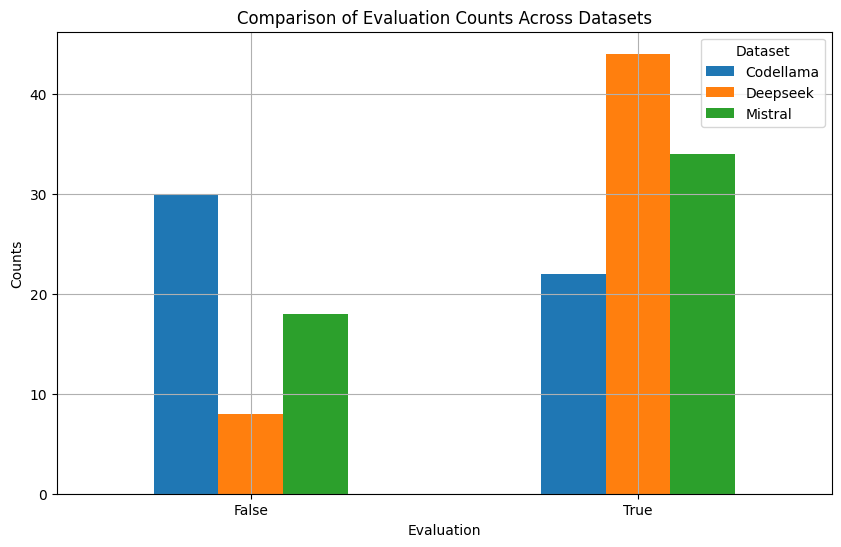

In [61]:
import pandas as pd
import matplotlib.pyplot as plt

# Normalize 'evaluation' column in each DataFrame
dataframes = {
    'Codellama': results_codellama,
    'Deepseek': results_deepseek,
    'Mistral': results_mistral,
}

# Create a DataFrame to store the counts
evaluation_counts = pd.DataFrame()

for name, df in dataframes.items():
    count = df['Evaluation'].value_counts().rename_axis('Evaluation').reset_index(name=name)
    if evaluation_counts.empty:
        evaluation_counts = count
    else:
        evaluation_counts = pd.merge(evaluation_counts, count, on='Evaluation', how='outer')

# Set index for plotting
evaluation_counts.set_index('Evaluation', inplace=True)

# Plotting
evaluation_counts.plot(kind='bar', figsize=(10, 6),color=['#1f77b4', '#ff7f0e', '#2ca02c'])
plt.title('Comparison of Evaluation Counts Across Datasets')
plt.xlabel('Evaluation')
plt.ylabel('Counts')
plt.xticks(rotation=0)
plt.grid(True)
plt.legend(title='Dataset')
plt.show()


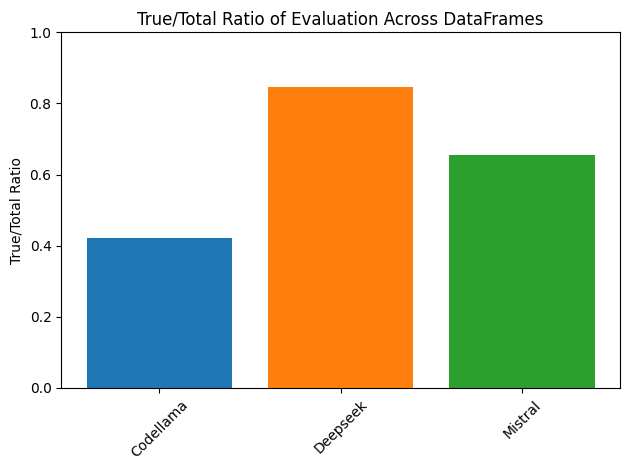

In [60]:
def calculate_true_ratio(df, column_name):
    if column_name in df.columns:
        value_counts = df[column_name].value_counts(normalize=True)
        return value_counts.get(True, 0)  # Returns 0 if True is not found
    return None

# Calculate ratios
true_ratios = {
    'Codellama': calculate_true_ratio(results_codellama, 'Evaluation'),
    'Deepseek': calculate_true_ratio(results_deepseek, 'Evaluation'),
    'Mistral': calculate_true_ratio(results_mistral, 'Evaluation'),
}

# Prepare the plot
fig, ax = plt.subplots()
ax.bar(true_ratios.keys(), true_ratios.values(), color=['#1f77b4', '#ff7f0e', '#2ca02c'])
ax.set_ylabel('True/Total Ratio')
ax.set_title('True/Total Ratio of Evaluation Across DataFrames')
ax.set_ylim([0, 1])  # Ensure the y-axis starts at 0 and ends at 1
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()

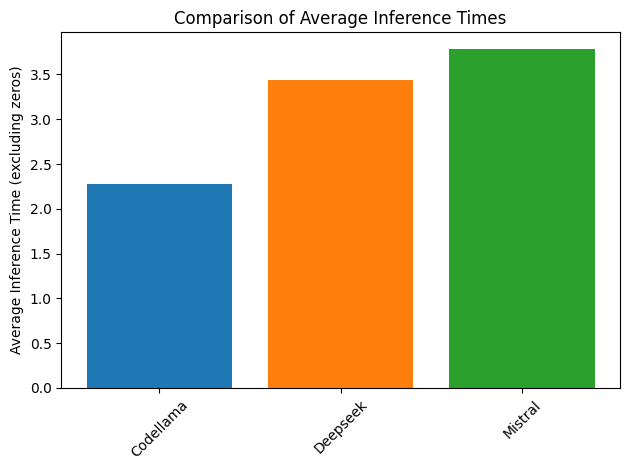

In [62]:
average_inference_time = {
    'Codellama':results_codellama['inference time'][results_codellama['inference time'] != 0].mean(),
    'Deepseek':results_deepseek['inference time'][results_deepseek['inference time'] != 0].mean(),
    'Mistral':results_mistral['inference time'][results_mistral['inference time'] != 0].mean()
}
fig, ax = plt.subplots()
ax.bar(average_inference_time.keys(), average_inference_time.values(), color=['#1f77b4', '#ff7f0e', '#2ca02c'])
ax.set_ylabel('Average Inference Time (excluding zeros)')
ax.set_title('Comparison of Average Inference Times')
plt.xticks(rotation=45)
plt.tight_layout()  # Adjust layout to make room for rotated x-labels

# Show the plot
plt.show()

In [54]:
true_ratios

{'Codellama ': 0.4230769230769231,
 'Deepseek': 0.8461538461538461,
 'Mistral': 0.6538461538461539}

In [49]:
average_inference_time

{'Codellama': 2.2758194498113684,
 'Deepseek': 3.4430570507049563,
 'Mistral': 3.781105268833249}

In [56]:
ratio_division = {key: true_ratios[key] / average_inference_time[key] for key in true_ratios if key in average_inference_time}


In [57]:
ratio_division

{'Codellama': 0.18590091718918644,
 'Deepseek': 0.2457565569471463,
 'Mistral': 0.17292460996408962}